# Sentiment Classification with Neural Networks

The purpose of this execise is to perform an natural language processing neural network training. This execise focuses on extracting reviews of Amazon foods using simple SQL, preprocess them, and train a machine learning model for sentiment classification on these reviews. 

Data source: [Kaggle]

In [1]:
import numpy as np
import pandas as pd
import sqlite3

import string
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
# Preliminary check for available devices for TensorFlow
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2489073597812587873, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6700198133
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4211195120088093976
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
conn = sqlite3.connect('database.sqlite')
cursor = conn.cursor()

### Find names of table

In [4]:
query = """
    SELECT name
    FROM sqlite_master
    """

cursor.execute(query).fetchall()

[('Reviews',)]

### Import data to dataframe

In [5]:
query="""
    SELECT *
    FROM Reviews
"""

df = pd.read_sql_query(query,conn)

In [6]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Data/Sentiment Profiling and Analysis

In [7]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

Check to see if the "HelpfulnessNumerator" and "HelpfulnessDenominator" columns are of any practical use.

In [8]:
df = df[df.HelpfulnessNumerator <= df.HelpfulnessDenominator]

**Result**: No entries were shown. Therefore, these two columns will be ignored for the rest of the analysis.

For simplicity, categorize the review scores into two labels: 'Negative' and 'Positive'. It is then necessary to examine the distribution of the scores.

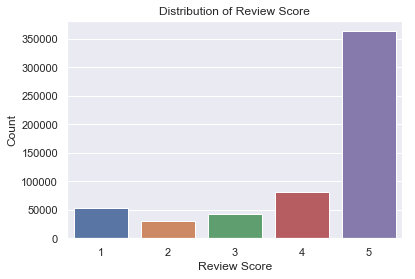

In [9]:
axis = plt.axes()
sns.countplot(df.Score, ax =axis)
axis.set_title('Distribution of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

In [10]:
df.Score.describe()

count    568452.000000
mean          4.183198
std           1.310438
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

The bar plot and the basic statistics show that the distribution is skewed towards the positive side. It is sensible to consider scores less than or equal to 3 as 'Negative' (Value = 0) and scores of 4 or 5 as 'Positive' (Value = 1).

In [11]:
# Add additional column called 'Sentiment' and label the scores accordingly.
df.loc[df.Score <= 3, 'Sentiment'] = 0
df.loc[df.Score > 3, 'Sentiment'] = 1

# If any, drop reviews submitted by the same user.
df.drop_duplicates(subset = {'UserId','ProfileName','Time'} ,keep = 'first', inplace = True)

In [12]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1.0


In [13]:
reviews = df['Text'].values

In [14]:
df.Score.describe()

count    352784.000000
mean          4.168707
std           1.326934
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

### Text processing and analysis

1. Remove any HTML tags (but also count the tags)
2. Convert words to lowercase
3. Remove email and web addression (but also count them)
4. Remove any signs and numbers
5. Remove any punctuations
5. Remove white sapces
6. Count number of words
7. Remove stopwords
8. Stem all words down to their root to simplify the modeling.

This entire process is done under the text_process function below. This is adopted from the article by Sonya Sawtelle who has written an [article](http://sdsawtelle.github.io/blog/output/spam-classification-part1-text-processing.html) on putting together a Spam email classifier. A few changes were made here to simplify the code a bit.

In [15]:
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))
tr = str.maketrans("","", string.punctuation)

In [17]:
def text_process(body):
    '''Produce a word salad from text body.'''    
    # Parse HTML extract content only (but count tags)
    soup = BeautifulSoup(body, 'html.parser')

    # Pull out only the non-markup tex
    body = soup.get_text()

    # Count the number of HTML elements and specific link elements
    ##nhtml = len(soup.find_all())
    ##nlinks = len(soup.find_all("a"))
    # Sub in special strings for "counting"
    ##body = body + nhtml*" htmltag " + nlinks*" linktag "
    
    # lowercase everything
    body = body.lower()
    
    # Replace all URLs with special strings
    #regx = re.compile(r"(http|https)://[^\s]*")
    #body, nhttps = regx.subn(repl=" httpaddr ", string=body)

    # Replace all email addresses with special strings
    #regx = re.compile(r"\b[^\s]+@[^\s]+[.][^\s]+\b")
    #body, nemails = regx.subn(repl=" emailaddr ", string=body)
    
    # Replace all numbers with special strings
    regx = re.compile(r"\b[\d.]+\b")
    body = regx.sub(repl=" ", string=body)
    #body = regx.sub(repl=" number ", string=body)

    # Replace all $, ! and ? with special strings
    #regx = re.compile(r"[$]")
    #body = regx.sub(repl=" dollar ", string=body)
    #regx = re.compile(r"[!]")
    #body = regx.sub(repl=" exclammark ", string=body)
    #regx = re.compile(r"[?]")
    #body = regx.sub(repl=" questmark ", string=body)

    # Remove all other punctuations (replace with white space)
    regx = re.compile(r"([^\w\s]+)|([_-]+)")  
    body = regx.sub(repl=" ", string=body)
    
    # Remove punctuations (replace with white space)
    #body = body.translate(tr)
    
    # Replace all newlines and blanklines with special strings
    #regx = re.compile(r"\n")
    #body = regx.sub(repl=" newline ", string=body)
    #regx = re.compile(r"\n\n")
    #body = regx.sub(repl=" blankline ", string=body)

    # Make all white space a single space
    regx = re.compile(r"\s+")
    body = regx.sub(repl=" ", string=body)

    # Remove any trailing or leading white space
    body = body.strip(" ")
 
    # Remove all useless stopwords
    bodywords = body.split(" ")
    keepwords = [word for word in bodywords if word not in stop_words]

    # Stem all words
    stemwords = [stemmer.stem(wd) for wd in keepwords]
    body = " ".join(stemwords)

    return body

Before processing:

In [18]:
body = reviews[5]
body

'I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.'

After processing:

In [19]:
text_process(body)

'got wild hair taffi order five pound bag taffi enjoy mani flavor watermelon root beer melon peppermint grape etc complaint bit much red black licoric flavor piec particular favorit kid husband last two week would recommend brand taffi delight treat'

#### Process all reviews

In [20]:
import time
reviews_cleaned = [""]*len(reviews)
t0 = time.time()
#for i in range(len(reviews)):
#    cleaned = text_process(reviews[i])
#    reviews_cleaned[i]=cleaned
df['Clean_Text'] = df['Text'].map(lambda s: text_process(s))
t1 = time.time()
print("Time to process without Dask {}".format(t1-t0))

Time to process without Dask 272.2656910419464


In [21]:
#-- SOME DASK PROTOTYPING, DOESN'T SEEM USEFUL FOR THIS TYPE OF OPERATION --##
#import dask.dataframe as dd
#ddf = dd.from_pandas(df, npartitions = 8)

#def text_process_df(df):
#    df['cleanText']= df['Text'].map(lambda s:text_process(s)) 
#    return df

#t0 = time.time()
#result = ddf.map_partitions(text_process_df)
#df2 = result.compute()
#t1 = time.time()
#print("Time to process with Dask {}".format(t1-t0))

In [22]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,Clean_Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.0,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1.0,great taffi great price wide assort yummi taff...


In [23]:
reviews = df['Clean_Text'].values
labels = df['Sentiment'].values

#### Build vocabulary frequency dictionary

In [24]:
def vocab_counter(reviews):
    vocab = dict()
    for txt in reviews:
        for word in txt.split():
            if word not in vocab:
                vocab[word] = 1
            else:
                vocab[word] += 1
    return vocab

In [25]:
import operator
# Sort dictionary from most to least
vocab = vocab_counter(reviews)
sorted_dict = sorted(vocab.items(), key=operator.itemgetter(1),reverse = True)

In [26]:
sorted_dict

[('like', 171843),
 ('tast', 165794),
 ('flavor', 128271),
 ('good', 124780),
 ('product', 119888),
 ('use', 115948),
 ('one', 115476),
 ('love', 108472),
 ('tri', 102937),
 ('great', 102331),
 ('coffe', 96172),
 ('tea', 92274),
 ('get', 85004),
 ('make', 81205),
 ('would', 76183),
 ('food', 74897),
 ('buy', 66731),
 ('time', 64617),
 ('realli', 61082),
 ('order', 59916),
 ('eat', 58885),
 ('amazon', 58357),
 ('much', 57615),
 ('price', 55407),
 ('also', 52584),
 ('find', 52028),
 ('littl', 50773),
 ('bag', 50282),
 ('drink', 50193),
 ('dog', 49590),
 ('even', 48336),
 ('best', 48024),
 ('well', 47501),
 ('store', 46142),
 ('cup', 45893),
 ('box', 43954),
 ('go', 43939),
 ('better', 43919),
 ('chocol', 42997),
 ('mix', 40925),
 ('day', 40457),
 ('water', 40032),
 ('sugar', 39995),
 ('look', 39274),
 ('year', 38298),
 ('first', 38273),
 ('sweet', 38116),
 ('packag', 37647),
 ('want', 36810),
 ('recommend', 36312),
 ('give', 35599),
 ('purchas', 34941),
 ('brand', 34802),
 ('found', 3474

In [27]:
vocab_ranking = dict()
rank = 1
for i in range(len(sorted_dict)):
    k = sorted_dict[i][0]
    vocab_ranking[k] = rank
    rank+=1

In [28]:
vocab_ranking

{'like': 1,
 'tast': 2,
 'flavor': 3,
 'good': 4,
 'product': 5,
 'use': 6,
 'one': 7,
 'love': 8,
 'tri': 9,
 'great': 10,
 'coffe': 11,
 'tea': 12,
 'get': 13,
 'make': 14,
 'would': 15,
 'food': 16,
 'buy': 17,
 'time': 18,
 'realli': 19,
 'order': 20,
 'eat': 21,
 'amazon': 22,
 'much': 23,
 'price': 24,
 'also': 25,
 'find': 26,
 'littl': 27,
 'bag': 28,
 'drink': 29,
 'dog': 30,
 'even': 31,
 'best': 32,
 'well': 33,
 'store': 34,
 'cup': 35,
 'box': 36,
 'go': 37,
 'better': 38,
 'chocol': 39,
 'mix': 40,
 'day': 41,
 'water': 42,
 'sugar': 43,
 'look': 44,
 'year': 45,
 'first': 46,
 'sweet': 47,
 'packag': 48,
 'want': 49,
 'recommend': 50,
 'give': 51,
 'purchas': 52,
 'brand': 53,
 'found': 54,
 'think': 55,
 'high': 56,
 'made': 57,
 'way': 58,
 'bought': 59,
 'work': 60,
 'treat': 61,
 'say': 62,
 'pack': 63,
 'free': 64,
 'enjoy': 65,
 'review': 66,
 'know': 67,
 'two': 68,
 'need': 69,
 'bit': 70,
 'thing': 71,
 'differ': 72,
 'sinc': 73,
 'could': 74,
 'nice': 75,
 'cat

In [29]:
encoded_txt = []
for txt in reviews:
    row_ = []
    for word in txt.split():
        row_.append(vocab_ranking[word])
    encoded_txt.append(row_)

# Alternative method for text encoding (via Keras one-hot func)
#from keras.preprocessing.text import one_hot
#encoded_docs = [one_hot(d, 95489) for d in reviews]

In [30]:
review_lengths = [len(rev) for rev in encoded_txt]
print("Shortest review:", min(review_lengths))
print("Longest review:",max(review_lengths))

Shortest review: 1
Longest review: 1959


[]

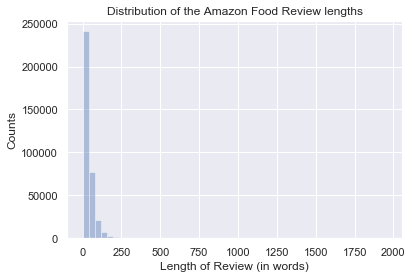

In [31]:
ax = plt.axes()
sns.distplot(review_lengths, kde=False)
ax.set_title("Distribution of the Amazon Food Review lengths")
plt.xlabel('Length of Review (in words)')
plt.ylabel('Counts')
plt.plot()

**Observation**: As shown in the plot above, most reviews (after text preprocessing) are less than 250 words in length. This tells us that one can limit the embedding vector length to about 200 without severe loss of information. Too long of an embedding vector can lead to very long training times.

### Splitting Dataset to Train, Validate, and Test sets

In [32]:
X = encoded_txt                 # Input feature
y = df['Sentiment'].values      # Output labels

In [33]:
# For practical reasons, consider fewer data. This also reduces training time
X = X[:70000]
y = y[:70000]

#### Padding the encoded text vector 

In [34]:
max_length = 200 # This was the length extrapolated from the above distribution
X = sequence.pad_sequences(X, maxlen = max_length, padding='pre')

In [35]:
X[1000]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

**Observation:** It seems that 'pre' padding leads to better training models with an LSTM layer. Apparently [others](https://arxiv.org/abs/1903.07288) reported this as well due to the nature of the LSTM layer.

In [36]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1500)

splitter = sss.split(X, y)
train_index, validation_index = next(splitter)
test_index = validation_index[:int(len(validation_index)/2)]
validation_index = validation_index[int(len(validation_index)/2):]

X_train, y_train = X[train_index], y[train_index]               # Training set
X_val, y_val = X[test_index], y[test_index]                     # Validation set
X_test, y_test = X[validation_index], y[validation_index]       # Testing set

print("Train set: {}".format(X_train.shape), 
      "\nValidation set: {}".format(X_val.shape),
      "\nTest set: {}".format(X_test.shape))

Train set: (56000, 200) 
Validation set: (7000, 200) 
Test set: (7000, 200)


In [37]:
def plot_metrics(hist):
    
    train_acc = hist.history['acc']
    train_loss = hist.history['loss']

    val_acc = hist.history['val_acc']
    val_loss = hist.history['val_loss']

    
    plt.subplot(211)
    plt.plot(train_loss, label='Training')
    plt.plot(val_loss, '--', label='Validation')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.subplot(212)
    plt.plot(train_acc)
    plt.plot(val_acc, '--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### Model 1: Embedding layer

In [38]:
input_dim = len(vocab.keys())
output_dim = 32

model = Sequential()
model.add(Embedding(input_dim, output_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           3055648   
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6401      
Total params: 3,062,049
Trainable params: 3,062,049
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
history = model.fit(X_train, y_train, epochs = 20, batch_size=64, verbose=1,validation_data=(X_val, y_val))
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Instructions for updating:
Use tf.cast instead.
Train on 56000 samples, validate on 7000 samples
Epoch 1/20
56000/56000 [==============================] - 7s 120us/step - loss: 0.3744 - acc: 0.8348 - val_loss: 0.3008 - val_acc: 0.8714
Epoch 2/20
56000/56000 [==============================] - 5s 97us/step - loss: 0.2656 - acc: 0.8909 - val_loss: 0.2985 - val_acc: 0.8761
Epoch 3/20
56000/56000 [==============================] - 5s 96us/step - loss: 0.2113 - acc: 0.9179 - val_loss: 0.3122 - val_acc: 0.8714
Epoch 4/20
56000/56000 [==============================] - 5s 97us/step - loss: 0.1591 - acc: 0.9434 - val_loss: 0.3304 - val_acc: 0.8674
Epoch 5/20
56000/56000 [==============================] - 5s 96us/step - loss: 0.1148 - acc: 0.9633 - val_loss: 0.3568 - val_acc: 0.8659
Epoch 6/20
56000/56000 [==============================] - 5s 97us/step - loss: 0.0809 - acc: 0.9776 - val_loss: 0.3906 - val_acc: 0.8600
Epoch 7/20
56000/56000 [==============================] - 5s 96us/step - loss: 0

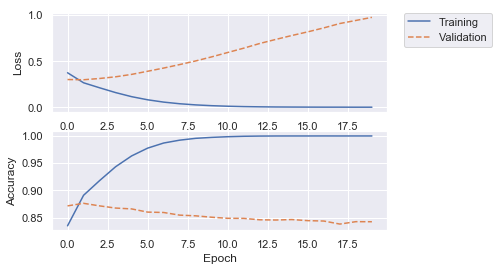

In [40]:
plot_metrics(history)

**Observation:** Although the training loss decreases in each epoch, the validation loss rises. This is an indication that there is overfitting in the modeling. One approach to alleviate this issue to apply dropout in the neural network. Also noted that the test accuracy for this model is 83.77%. 

### Model 2: Embedding + Dropout

In [41]:
input_dim = len(vocab.keys())
output_dim = 32

model_2 = Sequential()
model_2.add(Embedding(input_dim, output_dim, input_length=max_length))
model_2.add(Dropout(0.75))
model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           3055648   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6401      
Total params: 3,062,049
Trainable params: 3,062,049
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
history_2 = model_2.fit(X_train, y_train, epochs = 20, batch_size=64, verbose=1,validation_data=(X_val, y_val))
scores_2 = model_2.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores_2[1]*100))

Train on 56000 samples, validate on 7000 samples
Epoch 1/20
56000/56000 [==============================] - 6s 116us/step - loss: 0.4275 - acc: 0.8080 - val_loss: 0.3210 - val_acc: 0.8660
Epoch 2/20
56000/56000 [==============================] - 6s 105us/step - loss: 0.3144 - acc: 0.8648 - val_loss: 0.3014 - val_acc: 0.8734
Epoch 3/20
56000/56000 [==============================] - 6s 105us/step - loss: 0.2879 - acc: 0.8784 - val_loss: 0.2986 - val_acc: 0.8767
Epoch 4/20
56000/56000 [==============================] - 6s 105us/step - loss: 0.2702 - acc: 0.8907 - val_loss: 0.2984 - val_acc: 0.8751
Epoch 5/20
56000/56000 [==============================] - 6s 105us/step - loss: 0.2547 - acc: 0.8966 - val_loss: 0.3011 - val_acc: 0.8750
Epoch 6/20
56000/56000 [==============================] - 6s 105us/step - loss: 0.2433 - acc: 0.9004 - val_loss: 0.3050 - val_acc: 0.8744
Epoch 7/20
56000/56000 [==============================] - 6s 106us/step - loss: 0.2326 - acc: 0.9060 - val_loss: 0.3085 - v

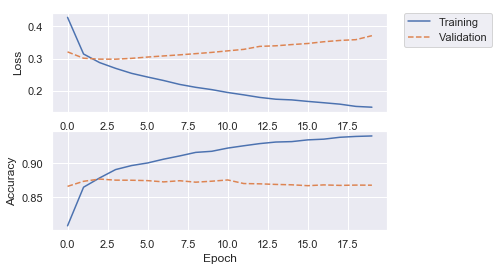

In [43]:
plot_metrics(history_2)

**Observation:** Similar observations from Model 1 can also be seen here but there is noticeable improvements on the validation loss in this model. There is also some improvements on the test accuracy for this model where a value of 85.74% is reported. Although the training accuracy for Model 2 is not as impressive as Model 1 but is still relatively decent.

Let us try adding more complexity to the model with a LSTM layer.

### Model 3: Embedding + Dropout + LSTM 

In [44]:
input_dim = len(vocab.keys())
output_dim = 32

model_3 = Sequential()
model_3.add(Embedding(input_dim, output_dim, input_length=max_length))
model_3.add(Dropout(0.75))
model_3.add(LSTM(100))
model_3.add(Dense(1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 32)           3055648   
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,108,949
Trainable params: 3,108,949
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
history_3 = model_3.fit(X_train, y_train, epochs = 20, batch_size=128, verbose=1,validation_data=(X_val, y_val))
scores_3 = model_3.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores_3[1]*100))

Train on 56000 samples, validate on 7000 samples
Epoch 1/20
56000/56000 [==============================] - 174s 3ms/step - loss: 0.4004 - acc: 0.8245 - val_loss: 0.3197 - val_acc: 0.8704
Epoch 2/20
56000/56000 [==============================] - 172s 3ms/step - loss: 0.3105 - acc: 0.8701 - val_loss: 0.3159 - val_acc: 0.8736
Epoch 3/20
56000/56000 [==============================] - 172s 3ms/step - loss: 0.2873 - acc: 0.8819 - val_loss: 0.2991 - val_acc: 0.8743
Epoch 4/20
56000/56000 [==============================] - 172s 3ms/step - loss: 0.2723 - acc: 0.8876 - val_loss: 0.3023 - val_acc: 0.8739
Epoch 5/20
56000/56000 [==============================] - 172s 3ms/step - loss: 0.2621 - acc: 0.8919 - val_loss: 0.2931 - val_acc: 0.8763
Epoch 6/20
56000/56000 [==============================] - 172s 3ms/step - loss: 0.2518 - acc: 0.8975 - val_loss: 0.2966 - val_acc: 0.8730
Epoch 7/20
56000/56000 [==============================] - 172s 3ms/step - loss: 0.2437 - acc: 0.9004 - val_loss: 0.2951 - v

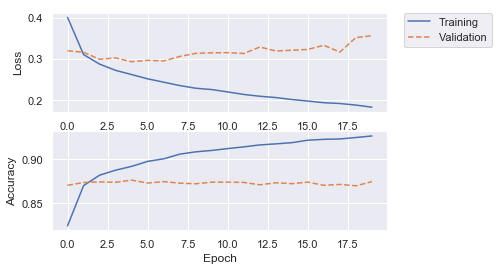

In [46]:
plot_metrics(history_3)

**Observations:** The loss and accuracy profiles for Model 3 are very similar to Model 2. The test accuracy of Model 3 is 86.8%, a very slight improvement from Model 2 at the same epoch. From the logs, it is obvious the training for this model is a lot longer than the previous ones. One then has to consider whether it is worth using this model since there is little to gain.

**Possible improvements**: Longer training times may improve Models 2 and 3. Using pre-trained word embeddings such as Word2Vec or GloVE would be an interesting extension to this execise. One can also continue to find optimal hyperparameters (e.g., embedding dimensions, dropout rate, batch sizes, etc.) but much time has already been spent here in tuning those parameters.